In [140]:
%matplotlib notebook 

import numpy as np
import os.path as op
import glob as glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from astropy import units as u
from astropy.coordinates import SkyCoord

# Plot LRS2 spec class

This class will extract your spectra for the channels you give it data for and plot a spectrum.

**Define your lsr2_spec object:**

1. The parameters `files_uv, files_or, files_re, files_fr` need to be given files lists of the spectrum files for 
   the uv, orange, red, and farred channels respectively. 
2. If you don't have data for a channel or dont want it plotted just put 'None' in for that channel's file. 
3. Default `scale`=1e16: This will scale the spectra values up by that factor 

**build_spec options:**

1. Default `combine`=False: if True will build a median spectra of the list of spectrum files for each channel. 
2. Default `smooth`=False: if True will smooth the spectra based on the conv_dict parameter. 
    you can give conv_dict a dictionary of the smoothing kernal size for each channel (only need channels used)

**plot_obj options:**

1. you must give the function the ax of your plot. This helps in building subplots of mulitple objects
2. Default `z`=None: You can set the redshift of the object and then it will plot emission line
3. Default `title`=None: This will change the title of the plot to the object name given
4. Default `save`=None: If you give save a path and filename.png it will save the plot to an output file. 


In [156]:
class lrs2_spec():
    def __init__(self, files_uv, files_or, files_re, files_fr, scale=1e16): 
        
        self.chan_dict = {'uv':{'files':files_uv, 'wave':[], 'spec': [], 'nois': [], 'c':0}, 
                          'or':{'files':files_or, 'wave':[], 'spec': [], 'nois': [], 'c':1},
                          're':{'files':files_re, 'wave':[], 'spec': [], 'nois': [], 'c':3},
                          'fr':{'files':files_fr, 'wave':[], 'spec': [], 'nois': [], 'c':5}}
        
        self.scale     = scale
        self.conv_dict = {'uv':1.0, 'or':1.0, 're':1.0, 'fr':1.0}
        self.max_spec = []
        
    def build_spec(self, combine=False, smooth=False, conv_dict=None):
        for chan in self.chan_dict:
            f = self.chan_dict[chan]['files']
            #will only build a channel spectrum if there is a filelist
            if f != None:
                #will combine if that option is True and there is multiple files in list 
                if (combine == True) and (len(f) > 1):
                    s_lis = []
                    w_lis = []
                    n_lis = []
                    #extracts each spectrum and wavelength solution and appends to list
                    for i in range(len(f)):
                        dat, hdr = fits.getdata(f[i], 0, header=True)
                        s = dat[1,:]*self.scale
                        w = dat[0,:]
                        n = dat[3,:]*self.scale
                        s_lis.append(s)
                        w_lis.append(w)
                        n_lis.append(n)
                    
                    #stacks all wavelength solutions for a channel in array
                    w_stack = np.vstack(w_lis)
                    #checks that each spec has same wavelength solution
                    if np.isclose(w_stack, w_stack[0]).all():
                        self.chan_dict[chan]['wave'] = w_lis[0]
                    else:
                        print ('Different wl solutions')
                    
                    #stacks all spectra and takes median of the stack
                    s_stack = np.vstack(s_lis)
                    stack_spec = np.median(s_stack, axis=0)
                    
                    #stacks all noise spectra and takes median of the stack
                    n_stack = np.vstack(n_lis)
                    stack_nois = np.median(n_stack, axis=0)
                    
                    #if smooth options choosen will use Gaussian kernal to smooth spectrum 
                    if smooth:
                        #will use default std dict for convolution of none given
                        #the default contains all 1.0 so no smoothing will occur 
                        if conv_dict==None:
                            conv_dict = self.conv_dict
                        conv_std = conv_dict[chan]
                        gauss_kernel = Gaussian1DKernel(conv_std)
                        self.chan_dict[chan]['spec'] = convolve(stack_spec*self.scale, gauss_kernel)
                        self.chan_dict[chan]['nois'] = convolve(stack_nois*self.scale, gauss_kernel)
                    else:    
                        self.chan_dict[chan]['spec'] = stack_spec*self.scale
                        self.chan_dict[chan]['nois'] = stack_nois*self.scale
                
                #If combine is False or there is only one spectrum in channel just extract first file
                else:
                    dat, hdr = fits.getdata(f[0], 0, header=True)
                    self.chan_dict[chan]['wave'] = dat[0,:]
                    
                    if smooth:
                        if conv_dict==None:
                            conv_dict = self.conv_dict
                        conv_std = conv_dict[chan]
                        gauss_kernel = Gaussian1DKernel(conv_std)
                        self.chan_dict[chan]['spec'] = convolve(dat[1,:]*self.scale, gauss_kernel)
                        self.chan_dict[chan]['nois'] = convolve(dat[3,:]*self.scale, gauss_kernel)
                    else:
                        self.chan_dict[chan]['spec'] = dat[1,:]*self.scale
                        self.chan_dict[chan]['nois'] = dat[3,:]*self.scale
                        
                #will find max of each spectrum for plot scaling 
                self.max_spec.append(np.amax(self.chan_dict[chan]['spec']))
                print (chan+': spectrum found')
                                                            
            else:
                print (chan+': NO FILE')
                self.chan_dict[chan]['files'] = None
            
    def write_ascii(self, outpath, t_int, name):
        print(t_int)
        for i in self.chan_dict:
            spec = self.chan_dict[i]['spec']/self.scale
            wave = self.chan_dict[i]['wave']
            nois = self.chan_dict[i]['nois']/self.scale
            AB = -2.5*np.log10(33400*spec*(wave**2))+8.8
            SN = spec / nois
            AB_lim = AB-2.5*np.log10(np.sqrt((t_int/3600)*(5/SN)/np.sqrt(4.1)))
            #df_dict = {'Flux':spec,'Wave':wave}
            df_dict = {'Wave':wave,'Flux':spec, 'AB':AB, 'S/N':SN, 'AB_lim':AB_lim}
            df_temp = pd.DataFrame(df_dict)
            df_temp.to_csv(op.join(outpath, i+'_spec_'+name+'.csv'))
            
    def plot_obj(self, ax, z=None, title=None, save=None):
        
        cp = sns.color_palette()
        
        #list of strong lines (in angstroms) to plot if redshift given 
        strong_lines = [3727, 3869, 4363, 4861, 4959, 5007, 6300, 6562, 6549, 6583, 6717, 6731]
        y_vals = np.linspace(-1, np.amax(self.max_spec)*10, 50)
        
        for chan in self.chan_dict:
            if self.chan_dict[chan]['files'] != None:
                w = self.chan_dict[chan]['wave']
                s = self.chan_dict[chan]['spec']
                #plot the spectrum in the color index defined in chan_dict
                ax.plot(w/(1+float(z)), s, color=cp[self.chan_dict[chan]['c']])
                
                #mark the 5577 sky line in the orange channel
                if chan=='or':
                    ax.fill_betweenx(y_vals, np.zeros(50)+5564, np.zeros(50)+5592, color=cp[7], alpha=0.4, zorder=1000)

                #if a redshift is given plot markers for emission lines
                if z != None:
                    wave_range = (np.amin(w), np.amax(w))
                    for s in strong_lines:
                        #checks what strong lines are in the given channel 
                        #s = s*(1.0+float(z))
                        if (wave_range[0] < s) and (s < wave_range[1]):
                            ax.plot(np.zeros(50)+s, y_vals, color=cp[7], ls=':')

        ax.set_ylim(-0.5, np.amax(self.max_spec)*1.5)
        #ax.set_ylim(-0.5, 3.0)
        #ax.set_xlim(6500, 6750)
        ax.set_xlabel(r'$Wavelength\ \AA$', fontsize=20, weight='bold')
        ax.set_ylabel(r'$Flux\ (ergs/s/cm^2/\AA)$ x('+str(1/self.scale)+')', fontsize=20)
        
        if title != None:
            if z != None:
                ax.set_title(title + ' (z='+str(z)+')', fontsize=25, weight='bold')
            else:
                ax.set_title(title, fontsize=25, weight='bold')

        if save != None:
            plt.savefig(save)

        plt.show()

# Build your object

## Define object properties 

Here you can define the name and the redshift of the object you observed

In [157]:
hdx_df = pd.read_csv('/Volumes/B_SS/HDX_OIII/hdx_oiii_lrs2.csv')

print(hdx_df.columns)
print()
print('Objects with Spectra:')
print(hdx_df[hdx_df['Observed']==True].Object.values)

Index(['Unnamed: 0', 'Object', 'In Queue', 'Observed', 'Spectrum', 'Channels',
       'Line_type', 'Proposal', 'Date', 'blue_obs', 'red_obs', 'z', 'Notes'],
      dtype='object')

Objects with Spectra:
[1000049084 1000476986 1000596323 1000544544 1000061639 1000390478
 1000394503 1000446418 1000253727 1000520424]


In [173]:
#define the object name 
hdx_obj = 1000520424

#define the redshift 
hdx_z = hdx_df[hdx_df['Object'] == hdx_obj].z.values[0]
print('z:', hdx_z)

#define the path parameters of the observation
obs_date = str(hdx_df[hdx_df['Object'] == hdx_obj].Date.values[0]).split('.')[0]
obs_prop = hdx_df[hdx_df['Object'] == hdx_obj].Proposal.values[0]
print('obs date:', obs_date)
print('proposal:', obs_prop)

red_obs =  hdx_df[hdx_df['Object'] == hdx_obj].red_obs.values[0]
blu_obs =  hdx_df[hdx_df['Object'] == hdx_obj].blue_obs.values[0]

if ~np.isnan(red_obs):
    red_obs = f"{int(red_obs):07d}"
    
if ~np.isnan(blu_obs):
    blu_obs = f"{int(blu_obs):07d}"

print('obs_folders:', blu_obs, red_obs)

z: 0.0841
obs date: 20191221
proposal: HET20-1-202
obs_folders: 0000018 0000019


## Load in data 

Here you want to define a list of spectrum files for each of the channels you have data for

In [174]:
datapath = '/Volumes/B_SS/HDX_OIII/LRS2_data'

if isinstance(blu_obs, str):
    files_uv = glob.glob(datapath+'/'+str(obs_prop)+'/spectrum_'+str(obs_date)+'_'+str(blu_obs)+'_exp01_uv.fits')
    files_or = glob.glob(datapath+'/'+str(obs_prop)+'/spectrum_'+str(obs_date)+'_'+str(blu_obs)+'_exp01_orange.fits')
    print ('uv:', len(files_uv), 'or:', len(files_or))
else:
    files_uv = None
    files_or = None
    
if isinstance(red_obs, str):
    files_re = glob.glob(datapath+'/'+str(obs_prop)+'/spectrum_'+str(obs_date)+'_'+str(red_obs)+'_exp01_red.fits')
    files_fr = glob.glob(datapath+'/'+str(obs_prop)+'/spectrum_'+str(obs_date)+'_'+str(red_obs)+'_exp01_farred.fits')
    print( 're:', len(files_re), 'fr:', len(files_fr))
else:
    files_re = None
    files_fr = None

uv: 1 or: 1
re: 1 fr: 1


## Call lrs2_spec class

In [175]:
#Define your oject 
hps_spec = lrs2_spec(files_uv, files_or, files_re, None, scale=1e16)

#Build your object spectrum 
hps_spec.build_spec(smooth=False)

uv: spectrum found
or: spectrum found
re: spectrum found
fr: NO FILE


In [176]:
#hps_spec.write_ascii('/Volumes/B_SS/HDX_OIII/LRS2_data', '1000049084')

<IPython.core.display.Javascript object>


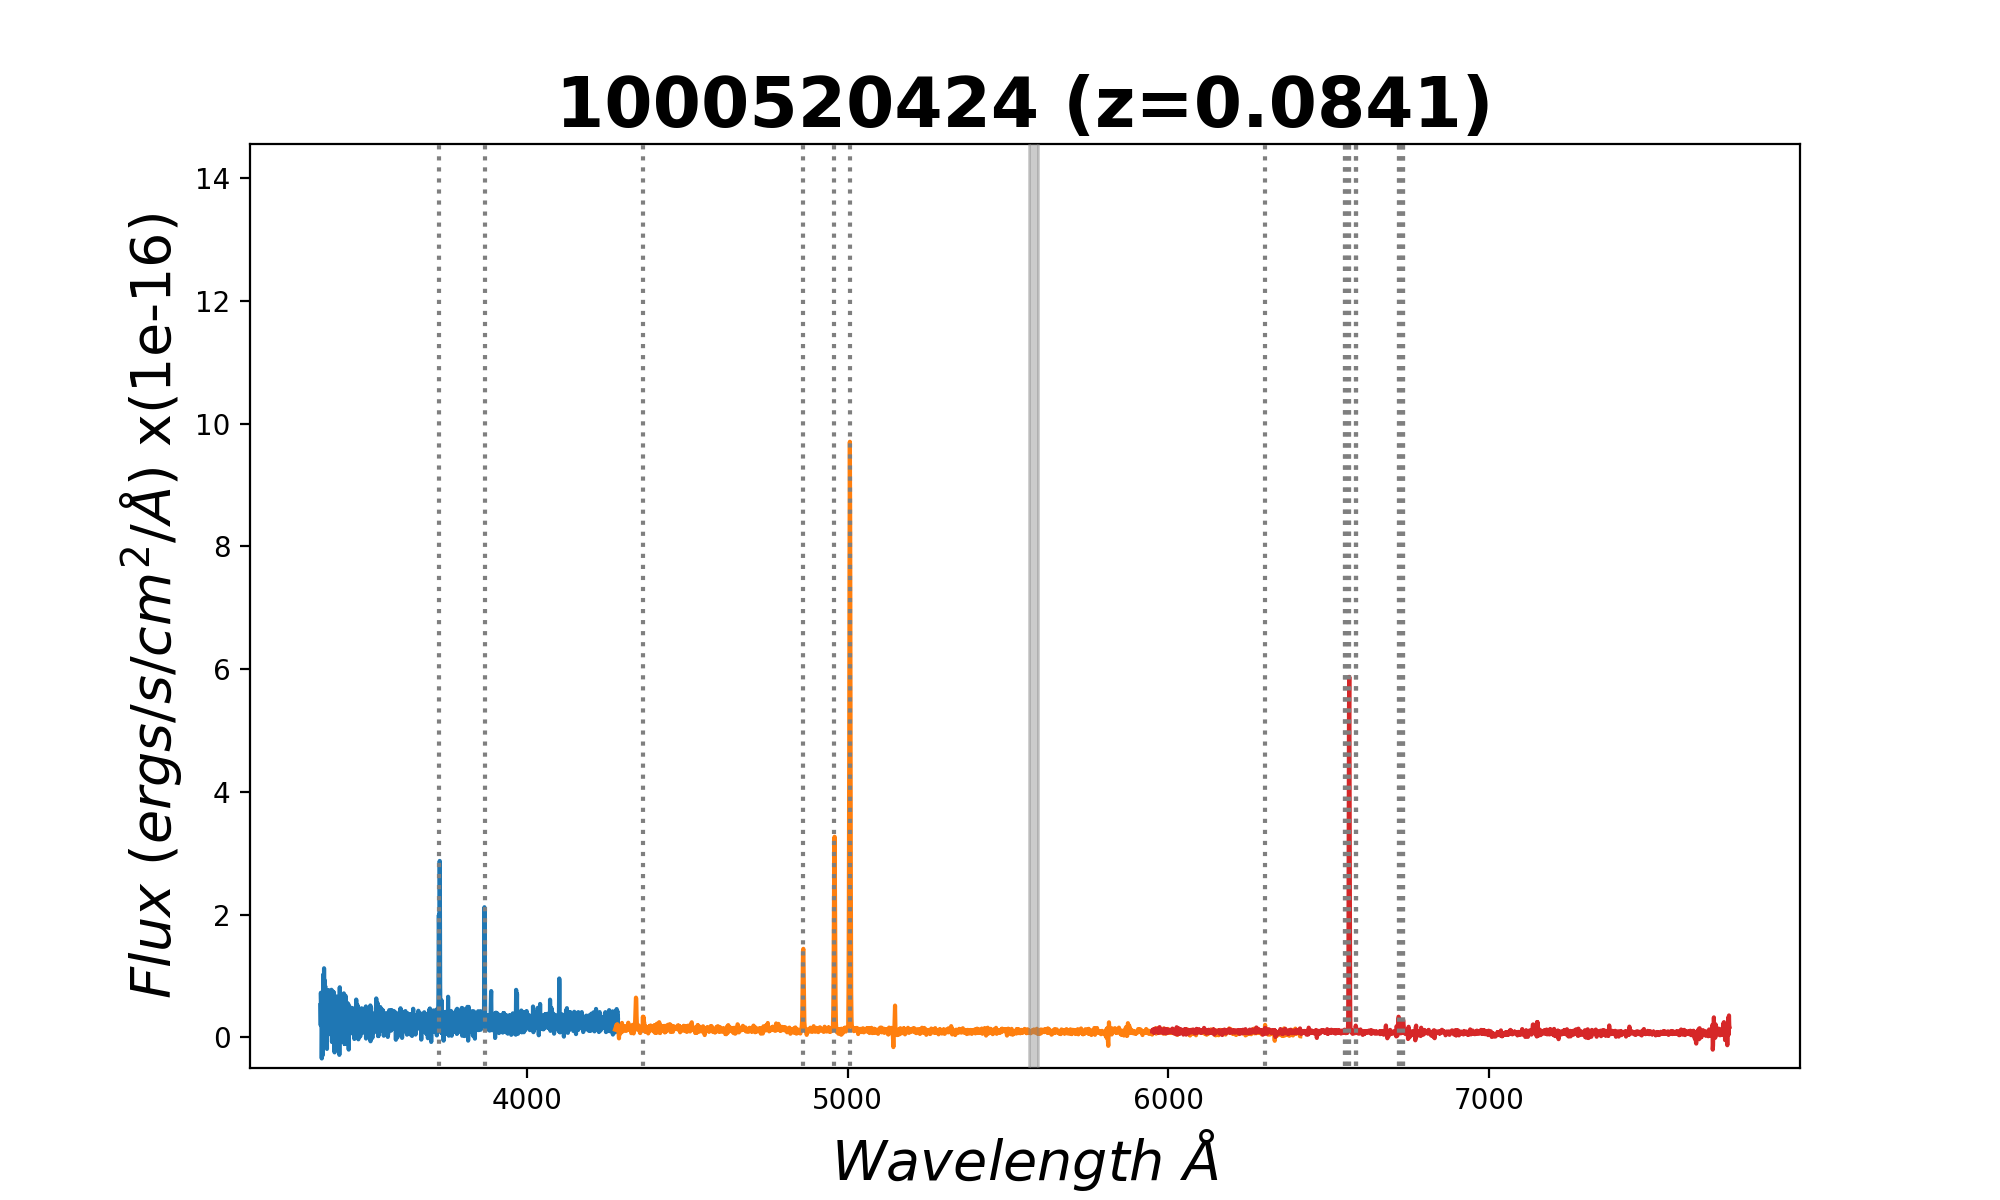

HET20-1-202


In [177]:
#Define your figure 
fig, ax = plt.subplots(figsize=(10,6))
#deine the path to save the plots
print(obs_prop)
plot_path = '/Volumes/B_SS/HDX_OIII/LRS2_data/'+obs_prop

#Plot your spectrum 
hps_spec.plot_obj(ax, title=str(hdx_obj), z=hdx_z, save=plot_path+'/'+str(hdx_obj)+'.png')